# Back Testing

In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [145]:
import FinanceDataReader as fdr

In [146]:
import plotly.express as plt
import plotly.graph_objects as go

In [147]:
def get_returns_df(df, N=1, log=False):
    if log: 
        return np.log(df/df.shift(N)).iloc[N-1:].fillna(0) # log수익률
    else:
        return df.pct_change(N, fill_method= None).iloc[N-1:].fillna(0) # 단순수익률
    
def get_cum_returns_df(return_df, log=False):
    if log:
        return np.exp(return_df.cumsum())
    else:
        return (1 + return_df).cumprod()

In [148]:
# 성과지표들

def get_annualized_returns_series(log_return_df, num_day_in_year=250):
    return(log_return_df.mean()*num_day_in_year).round(2)

def get_annualized_std_series(log_return_df, num_day_in_year=250):
    return (log_return_df.std() * (num_day_in_year ** 0.5)).round(2)


def get_cagr_series(cum_rtn_df, num_day_in_year= 250):
    cagr_series = cum_rtn_df.iloc[-1]**(num_day_in_year/(len(cum_rtn_df)))-1
    return cagr_series


def get_sharpe_ratio(log_rtn_df, yearly_rfr = 0.025):
    excess_rtns = log_rtn_df.mean()*252 -yearly_rfr
    return excess_rtns / (log_rtn_df.std() * np.sqrt(252))

def get_drawdown_infos(cum_returns_df):
    cummax_df = cum_returns_df.cummax()
    dd_df = cum_returns_df / cummax_df -1
    
    mdd_series = dd_df.min()
    
    max_point_df = dd_df[dd_df==0]
    
    first_df = max_point_df.index[:-1]
    second_df = max_point_df.index[1:]
    
    period = second_df-first_df
    
    longest_dd_period = period.max().days
    
    ldd_st = first_df[period.argmax()]
    ldd_ed = second_df[period.argmax()]
    
    return mdd_series, longest_dd_period, ldd_st, ldd_ed

In [149]:
def backtest_eval(str_cum_rtn, str_rtn): # 열 이름(전략적누적수익, 전략적수익) 대입
    
    cagr = get_cagr_series(df[str_cum_rtn], num_day_in_year = 250)
    sharp_ratio = get_sharpe_ratio(df[str_rtn], yearly_rfr = 0.025)
    mdd, ldd_period, ldd_st, ldd_ed = get_drawdown_infos(df[str_cum_rtn])

    print('cagr :', cagr)
    print('sharp_ratio :', sharp_ratio)
    print('Max_drawdown :', mdd)
    print('Longest_dd_period :', ldd_period)
    print('Longest_dd_st_date :', ldd_st)
    print('Longest_dd_ed_date :', ldd_ed)

## 이동평균선 매매전략

In [102]:
df = fdr.DataReader('005930', '2010-01-02', '2020-10-30')
df

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2010-01-04,16060,16180,16000,16180,239271,0.012516
2010-01-05,16520,16580,16300,16440,559219,0.016069
2010-01-06,16580,16820,16520,16820,459755,0.023114
2010-01-07,16820,16820,16260,16260,443237,-0.033294
2010-01-08,16400,16420,16120,16420,295798,0.009840
...,...,...,...,...,...,...
2020-10-26,60400,61100,60100,60400,13268226,0.003322
2020-10-27,60300,60300,59500,59800,17260416,-0.009934
2020-10-28,59400,59400,58800,59000,14428882,-0.013378


In [103]:
# 단기 이동평균선 (short moving average)
# 장기 이동평균선
df['sma'] = df.Close.rolling(5).mean()
df['lma'] = df.Close.rolling(20).mean()

In [104]:
df.head()

,Open,High,Low,Close,Volume,Change,sma,lma
Date,,,,,,,,
2010-01-04,16060,16180,16000,16180,239271,0.012516,NaN,NaN
2010-01-05,16520,16580,16300,16440,559219,0.016069,NaN,NaN
2010-01-06,16580,16820,16520,16820,459755,0.023114,NaN,NaN
2010-01-07,16820,16820,16260,16260,443237,-0.033294,NaN,NaN
2010-01-08,16400,16420,16120,16420,295798,0.009840,16424.0,NaN


In [105]:
df.dropna(inplace=True)

<AxesSubplot:xlabel='Date'>

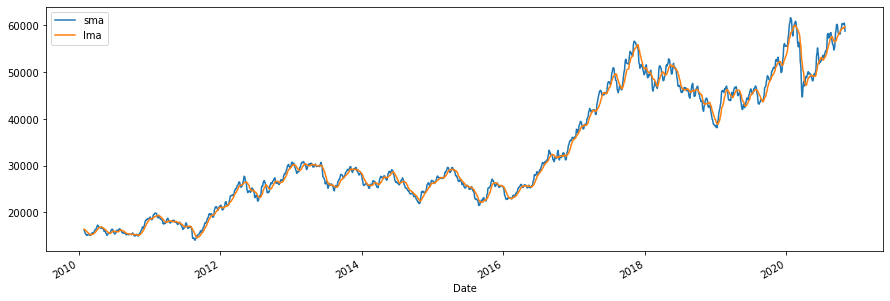

In [106]:
df[['sma','lma']].plot(figsize=(15,5))

<AxesSubplot:xlabel='Date'>

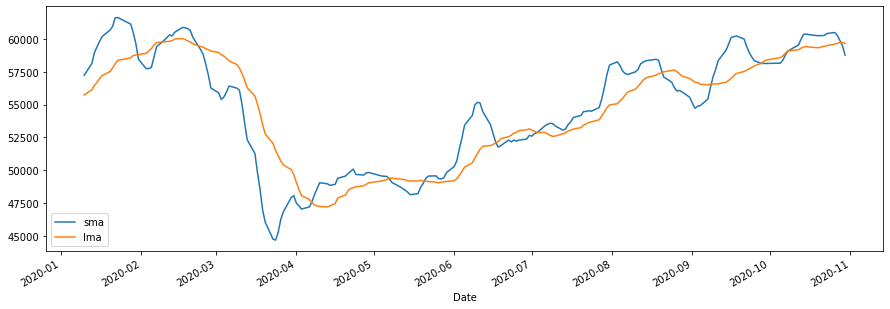

In [107]:
# df[['Close','sma','lma']].iloc[-200:].plot(figsize=(15,5))
df[['sma','lma']].iloc[-200:].plot(figsize=(15,5))


In [108]:
# 매수 매도 포지션 : 단기가 장기보다 클때
# 이동평균선 매매 기본전략

df['position'] = np.where(df['sma']>=df['lma'],1,0)

<AxesSubplot:xlabel='Date'>

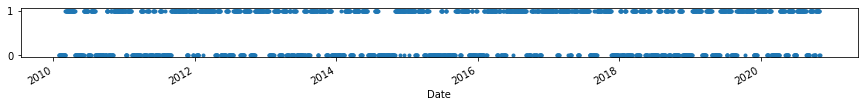

In [109]:
df['position'].plot(marker='.', linestyle='none', figsize=(15,1))

<AxesSubplot:xlabel='Date'>

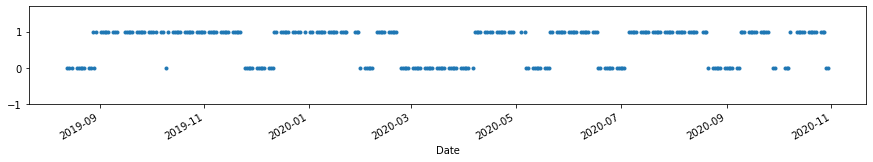

In [110]:
df['position'][-300:].plot(marker='.', linestyle='none', figsize=(15,2), ylim=[-1.01,1.7])

In [111]:
long_index = df[(df['position']-df['position'].shift(1))== 1].index
exit_index = df[(df['position']-df['position'].shift(1))== -1].index

In [112]:
long_index

DatetimeIndex(['2010-03-05', '2010-06-08', '2010-07-14', '2010-10-04',
               '2010-10-26', '2010-11-08', '2011-01-18', '2011-03-29',
               '2011-04-27', '2011-05-02', '2011-06-01', '2011-07-05',
               '2011-08-03', '2011-09-01', '2011-11-30', '2011-12-26',
               '2012-01-25', '2012-02-15', '2012-04-26', '2012-06-12',
               '2012-07-19', '2012-09-12', '2012-11-06', '2013-02-13',
               '2013-03-29', '2013-05-03', '2013-05-21', '2013-05-30',
               '2013-07-17', '2013-07-25', '2013-08-19', '2013-10-02',
               '2013-11-20', '2014-01-27', '2014-02-13', '2014-03-31',
               '2014-05-14', '2014-07-18', '2014-10-30', '2014-11-27',
               '2014-12-19', '2015-01-13', '2015-02-25', '2015-04-09',
               '2015-04-22', '2015-06-25', '2015-07-02', '2015-07-21',
               '2015-09-08', '2015-10-07', '2015-12-01', '2015-12-22',
               '2015-12-24', '2016-02-02', '2016-02-17', '2016-04-18',
      

<AxesSubplot:xlabel='Date'>

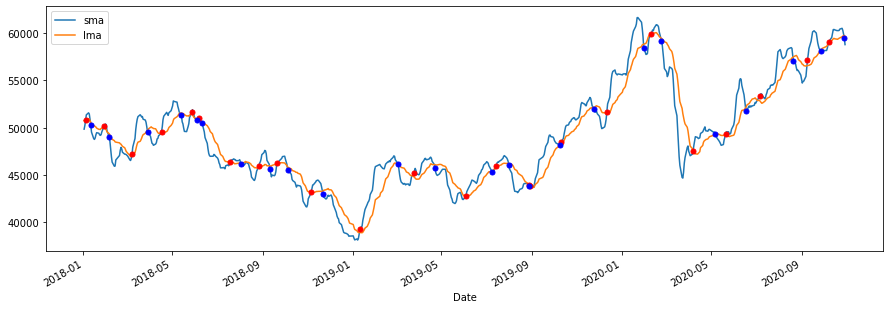

In [113]:
df[['sma','lma']].loc['2018-01-01':].plot(figsize=(15,5))
df.loc[long_index,'sma'].loc['2018-01-01':].plot(marker='o',color='red',linestyle='none',markersize=5)
df.loc[exit_index,'sma'].loc['2018-01-01':].plot(marker='o',color='blue',linestyle='none',markersize=5)

In [114]:
df.loc[:,'rtn'] = get_return_df(df['Close'],N=1,log=True)
df

,Open,High,Low,Close,Volume,Change,sma,lma,position,rtn
Date,,,,,,,,,,
2010-01-29,16000,16019,15600,15680,457285,-0.029703,16196.0,16402.0,0,0.000000
2010-02-01,15679,15700,15300,15540,501042,-0.008929,15936.0,16370.0,0,-0.008969
2010-02-02,15800,15800,15400,15440,393803,-0.006435,15764.0,16320.0,0,-0.006456
2010-02-03,15640,15700,15360,15540,330235,0.006477,15672.0,16256.0,0,0.006456
2010-02-04,15500,15660,15440,15520,239799,-0.001287,15544.0,16219.0,0,-0.001288
...,...,...,...,...,...,...,...,...,...,...
2020-10-26,60400,61100,60100,60400,13268226,0.003322,60500.0,59610.0,1,0.003317
2020-10-27,60300,60300,59500,59800,17260416,-0.009934,60280.0,59670.0,1,-0.009983
2020-10-28,59400,59400,58800,59000,14428882,-0.013378,59900.0,59730.0,1,-0.013468


In [115]:
# 투자전략 수익률
df.loc[:,'str_rtn'] = (df['position'].shift(1)*df['rtn']).fillna(0)

In [116]:
# 투자전략 수익률의 누적합
df.loc[:,'cum_str_rtn'] = get_cum_returns_df(df['str_rtn'],log=True)

In [117]:
df

,Open,High,Low,Close,Volume,Change,sma,lma,position,rtn,str_rtn,cum_str_rtn
Date,,,,,,,,,,,,
2010-01-29,16000,16019,15600,15680,457285,-0.029703,16196.0,16402.0,0,0.000000,0.000000,1.000000
2010-02-01,15679,15700,15300,15540,501042,-0.008929,15936.0,16370.0,0,-0.008969,-0.000000,1.000000
2010-02-02,15800,15800,15400,15440,393803,-0.006435,15764.0,16320.0,0,-0.006456,-0.000000,1.000000
2010-02-03,15640,15700,15360,15540,330235,0.006477,15672.0,16256.0,0,0.006456,0.000000,1.000000
2010-02-04,15500,15660,15440,15520,239799,-0.001287,15544.0,16219.0,0,-0.001288,-0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-26,60400,61100,60100,60400,13268226,0.003322,60500.0,59610.0,1,0.003317,0.003317,1.352149
2020-10-27,60300,60300,59500,59800,17260416,-0.009934,60280.0,59670.0,1,-0.009983,-0.009983,1.338717
2020-10-28,59400,59400,58800,59000,14428882,-0.013378,59900.0,59730.0,1,-0.013468,-0.013468,1.320808


In [118]:
cagr = get_cagr_series(df['cum_str_rtn'], num_day_in_year=250)
sharp_ratio =get_sharpe_ratio(df['str_rtn'], yearly_rfr = 0.025)

In [119]:
mdd_series, longest_dd_period, ldd_sd, ldd_ed = get_drawdown_infos(df['cum_str_rtn'])

In [120]:
print('cagr: ',cagr)
print('sharp_ratio: ', sharp_ratio)
print('최대하락폭: ',mdd_series)
print('최대하락기간: ', longest_dd_period)
print('하락시작기간: ', ldd_sd)
print('하락끝기간: ', ldd_ed)

cagr:  1.025080520098154
sharp_ratio:  -0.00016068342693508565
최대하락폭:  -0.36030614769557534
최대하락기간:  1764
하락시작기간:  2013-01-02 00:00:00
하락끝기간:  2017-11-01 00:00:00


## 모멘텀 전략

In [121]:
df = fdr.DataReader('005930','2018-01-02','2022-04-29')

In [122]:
# 3달 모멘텀
momentum_window = 20 * 3

In [123]:
# np.sign: 0보다 크면 1 작으면 -1 반환
position = np.sign(get_return_df(df['Close'],N=momentum_window)) # 3달후 수익률이 0보다 크면 1, 작으면 -1
position.head()

Date
2018-03-29    0.0
2018-03-30   -1.0
2018-04-02   -1.0
2018-04-03   -1.0
2018-04-04   -1.0
Name: Close, dtype: float64

In [124]:
position.value_counts()

 1.0    537
-1.0    464
 0.0      5
Name: Close, dtype: int64

In [125]:
# 매수 포지션만 사용 -> 주식을 가지고 있거나(1), 가지고 있지 않거나(-1)
position[position ==-1] = 0

In [126]:
position.value_counts()

1.0    537
0.0    469
Name: Close, dtype: int64

<AxesSubplot:xlabel='Date'>

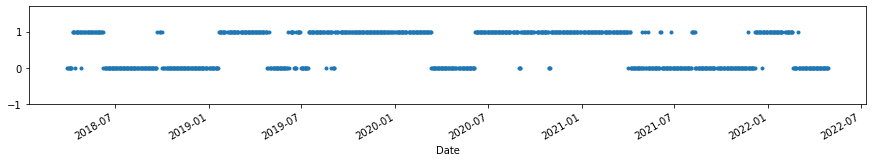

In [127]:
position.plot(marker='.', linestyle='none', figsize=(15,2), ylim=[-1.01,1.7])

In [128]:
df.loc[:,'position'] = position

In [129]:
df.dropna(inplace=True)

In [130]:
df

,Open,High,Low,Close,Volume,Change,position
Date,,,,,,,
2018-03-29,48700,49560,48320,49040,201340,0.006982,0.0
2018-03-30,49080,49900,49080,49220,155542,0.003670,0.0
2018-04-02,49000,49220,48500,48540,142313,-0.013816,0.0
2018-04-03,47880,48140,47280,48120,255365,-0.008653,0.0
2018-04-04,48160,48260,46920,46920,247684,-0.024938,0.0
...,...,...,...,...,...,...,...
2022-04-22,67200,67300,66700,67000,11791478,-0.010340,0.0
2022-04-25,66500,66700,66300,66300,11016474,-0.010448,0.0
2022-04-26,66400,66700,66100,66100,12946923,-0.003017,0.0


In [131]:
# 0 ->1 바뀔때
long_index = df[(df['position']-df['position'].shift(1))== 1].index

# 1->0 바뀔때
exit_index = df[(df['position']-df['position'].shift(1))== -1].index

<AxesSubplot:xlabel='Date'>

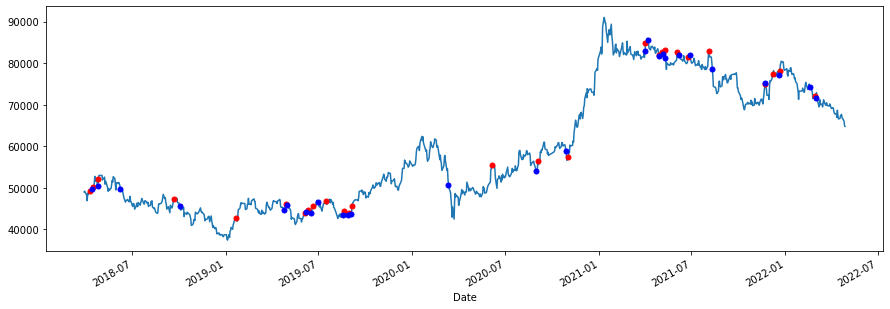

In [132]:
ax = df.loc[:,'Close'].loc['2018-01-01':].plot(figsize=(15,5))

df.loc[long_index,'Close'].loc['2018-01-01':].plot(marker='o',color='red',linestyle='none',markersize=5)
df.loc[exit_index,'Close'].loc['2018-01-01':].plot(marker='o',color='blue',linestyle='none',markersize=5)

In [133]:
df.loc[:, 'rtn'] = get_returns_df(df['Close'], N=1, log=True)
df.loc[:, 'str_rtn'] = (df['position'].shift(1) * df['rtn']).fillna(0)

df.loc[:, 'cum_str_rtn'] = get_cum_returns_df(df['str_rtn'], log=True)

In [134]:
cagr = get_cagr_series(df['cum_str_rtn'], num_day_in_year = 250)
sharp_ratio = get_sharpe_ratio(df['str_rtn'], yearly_rfr = 0.025)
mdd, ldd_period, ldd_st, ldd_ed = get_drawdown_infos(df['cum_str_rtn'])

In [135]:
print('cagr :', cagr)
print('sharp_ratio :', sharp_ratio)
print('Max_drawdown :', mdd_series)
print('Longest_dd_period :', ldd_period)
print('Longest_dd_st_date :', ldd_st)
print('Longest_dd_ed_date :', ldd_ed)

cagr : 1.0567925409962098
sharp_ratio : 0.16541971431568003
Max_drawdown : -0.36030614769557534
Longest_dd_period : 607
Longest_dd_st_date : 2018-04-19 00:00:00
Longest_dd_ed_date : 2019-12-17 00:00:00


<AxesSubplot:xlabel='Date'>

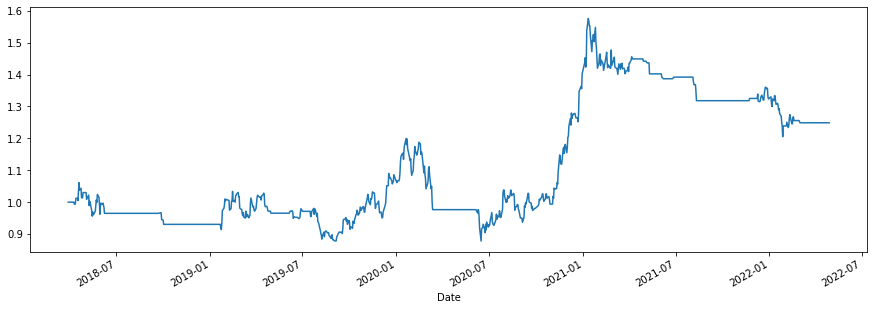

In [136]:
df.loc[:, 'cum_str_rtn'].plot(figsize=(15,5))

In [138]:
def momentum(df, mw):
    
    momentum_window=mw
    
    position = np.sign(get_returns_df(df['Close'], N=momentum_window))
    position[position == -1] = 0
    
    df.loc[:, 'position'] = position
    df.dropna(inplace=True)
    
    df.loc[:, 'rtn'] = get_returns_df(df['Close'], N=1, log=True)
    df.loc[:, 'str_rtn'] = (df['position'].shift(1) * df['rtn']).fillna(0)

    df.loc[:, 'cum_str_rtn'] = get_cum_returns_df(df['str_rtn'], log=True)
    
    cagr = get_cagr_series(df['cum_str_rtn'], num_day_in_year = 250)
    sharp_ratio = get_sharpe_ratio(df['str_rtn'], yearly_rfr = 0.025)
    mdd, ldd_period, ldd_st, ldd_ed = get_drawdown_infos(df['cum_str_rtn'])
    
    print('cagr :', cagr)
    print('sharp_ratio :', sharp_ratio)
    print('Max_drawdown :', mdd_series)
    print('Longest_dd_period :', ldd_period)
    print('Longest_dd_st_date :', ldd_st)
    print('Longest_dd_ed_date :', ldd_ed)
    
    df.loc[:, 'cum_str_rtn'].plot(figsize=(15,5))

cagr : 0.987198424896133
sharp_ratio : -0.11121261924501334
Max_drawdown : -0.36030614769557534
Longest_dd_period : 13
Longest_dd_st_date : 2018-05-15 00:00:00
Longest_dd_ed_date : 2018-05-28 00:00:00


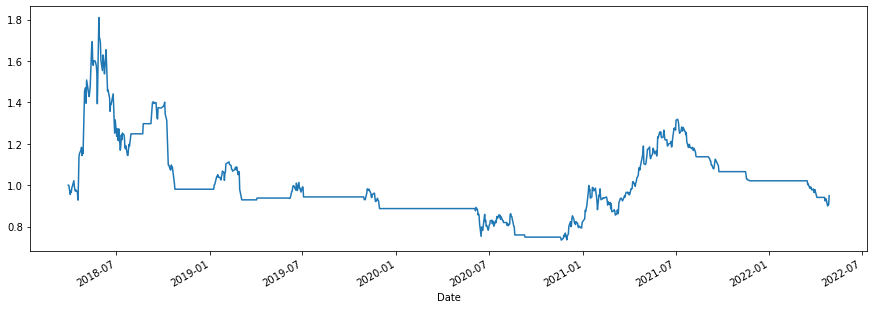

In [139]:
df = fdr.DataReader('000720','2018-01-02','2022-04-29')
mw = 60

momentum(df, mw)

## Mean Reverse전략

In [122]:
df = fdr.DataReader('005930','2020-01-02','2022-04-30')
df.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2020-01-02,55500,56000,55000,55200,12993228,-0.010753
2020-01-03,56000,56600,54900,55500,15422255,0.005435
2020-01-06,54900,55600,54600,55500,10278951,0.000000
2020-01-07,55700,56400,55600,55800,10009778,0.005405
2020-01-08,56200,57400,55900,56800,23501171,0.017921


In [123]:
df = df[['Close']]
df

,Close
Date,
2020-01-02,55200
2020-01-03,55500
2020-01-06,55500
2020-01-07,55800
2020-01-08,56800
...,...
2022-04-25,66300
2022-04-26,66100
2022-04-27,65000


In [124]:
window = 20 
df.loc[:,'sma'] = df['Close'].rolling(window).mean()

In [125]:
rolling_std = df['Close'].rolling(window).std()

In [126]:
df.dropna(inplace=True)

<AxesSubplot:xlabel='Date'>

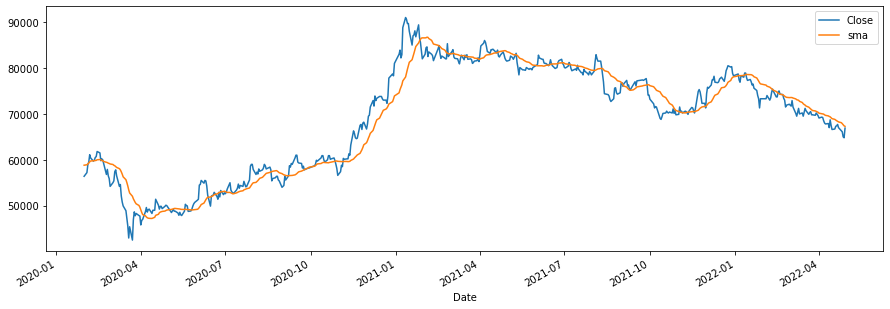

In [127]:
df.plot(figsize=(15,5))

In [128]:
df['+threshold'] = df['sma']+ 2*rolling_std
df['-threshold'] = df['sma']- 2*rolling_std

In [129]:
df.head()

,Close,sma,+threshold,-threshold
Date,,,,
2020-01-31,56400,58815.0,63526.140213,54103.859787
2020-02-03,57200,58915.0,63381.612987,54448.387013
2020-02-04,58900,59085.0,63253.187793,54916.812207
2020-02-05,59500,59285.0,63097.596850,55472.403150
2020-02-06,61100,59550.0,63068.073636,56031.926364


<AxesSubplot:xlabel='Date'>

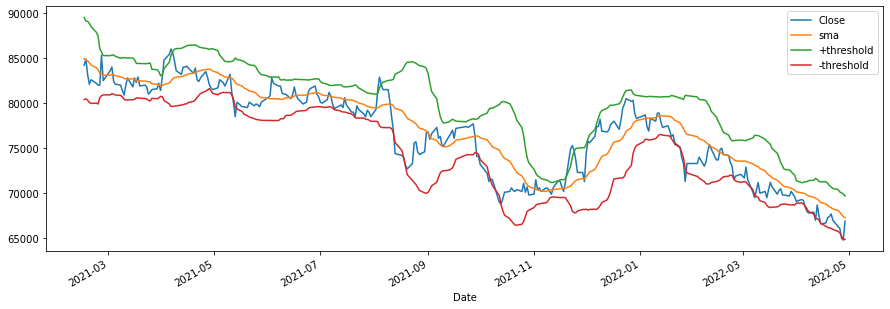

In [130]:
df[['Close','sma','+threshold','-threshold']].iloc[-300:].plot(figsize=(15,5))

In [131]:
pos1 = np.where(df['Close'] <= df['-threshold'], 1,0) # 매수
pos2 = np.where(df['Close'] >= df['+threshold'],-1,0) # 매도

df.loc[:,'position'] = pos1 + pos2

In [132]:
df

,Close,sma,+threshold,-threshold,position
Date,,,,,
2020-01-31,56400,58815.0,63526.140213,54103.859787,0
2020-02-03,57200,58915.0,63381.612987,54448.387013,0
2020-02-04,58900,59085.0,63253.187793,54916.812207,0
2020-02-05,59500,59285.0,63097.596850,55472.403150,0
2020-02-06,61100,59550.0,63068.073636,56031.926364,0
...,...,...,...,...,...
2022-04-25,66300,68085.0,70412.207498,65757.792502,0
2022-04-26,66100,67880.0,70144.229856,65615.770144,0
2022-04-27,65000,67635.0,70035.241216,65234.758784,1


<AxesSubplot:xlabel='Date'>

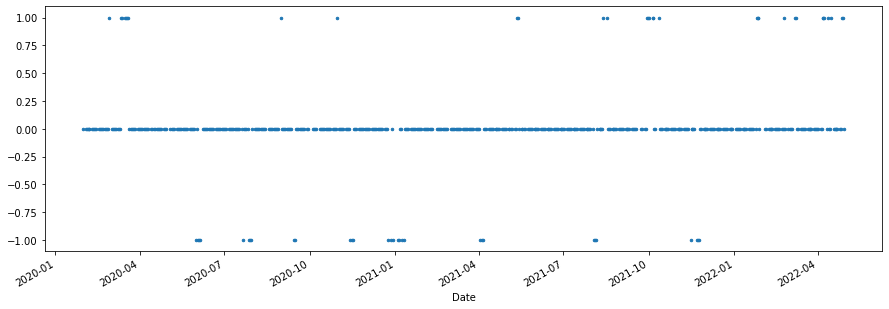

In [133]:
df['position'].plot(
    marker='.', linestyle='none', markersize=5, figsize=(15,5)
)

In [134]:
# 우리나라엔 매도 포지션없지만 구현
# 현재포지션 매도(-1) & 현재포지션0 전날포지션 1 
short_index = df[
    ((df['position']-df['position'].shift()) == -1)& (df['position']== -1)
].index
short_index

DatetimeIndex(['2020-06-01', '2020-06-03', '2020-07-21', '2020-07-28',
               '2020-09-14', '2020-11-13', '2020-12-24', '2020-12-30',
               '2021-01-08', '2021-04-02', '2021-08-03', '2021-11-15',
               '2021-11-22'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [135]:
long_index = df[
    ((df['position']-df['position'].shift()) == 1)& (df['position']== 1)
].index
long_index

DatetimeIndex(['2020-02-28', '2020-03-12', '2020-08-31', '2020-10-30',
               '2021-05-12', '2021-08-13', '2021-09-29', '2021-10-12',
               '2022-01-25', '2022-02-24', '2022-03-07', '2022-04-06',
               '2022-04-12', '2022-04-15', '2022-04-27'],
              dtype='datetime64[ns]', name='Date', freq=None)

<AxesSubplot:xlabel='Date'>

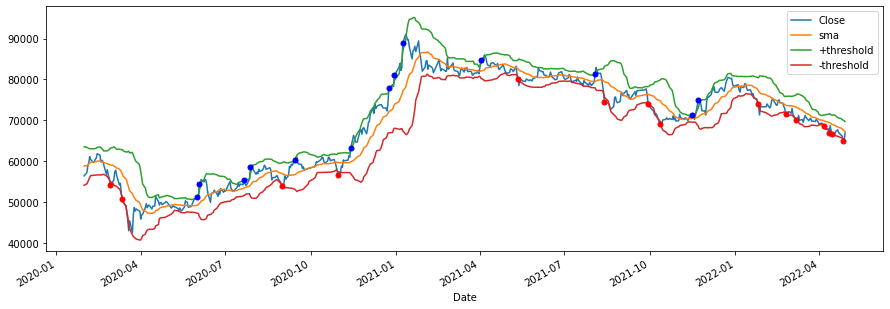

In [136]:
ax = df[['Close','sma','+threshold','-threshold']].loc['2018-01-01':].plot(figsize=(15,5))

df.loc[long_index,'Close'].plot(ax=ax,marker='o',color='red',linestyle='none',markersize=5)
df.loc[short_index,'Close'].plot(ax=ax,marker='o',color='blue',linestyle='none',markersize=5)

In [137]:
df.loc[:, 'rtn'] = get_returns_df(df['Close'], log=True)
df.loc[:, 'str_rtn'] = (df['position'].shift() * df['rtn']).fillna(0)

In [138]:
df.loc[:, 'cum_rtn'] = get_cum_returns_df(df['rtn'], log=True)
df.loc[:, 'str_cum_rtn'] = get_cum_returns_df(df['str_rtn'], log=True)

<AxesSubplot:xlabel='Date'>

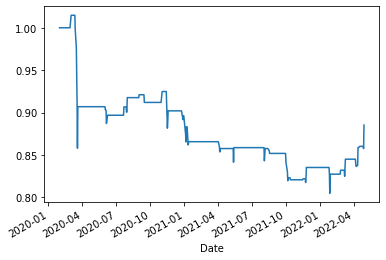

In [139]:
df['str_cum_rtn'].plot()

In [140]:
df

,Close,sma,+threshold,-threshold,position,rtn,str_rtn,cum_rtn,str_cum_rtn
Date,,,,,,,,,
2020-01-31,56400,58815.0,63526.140213,54103.859787,0,0.000000,0.000000,1.000000,1.000000
2020-02-03,57200,58915.0,63381.612987,54448.387013,0,0.014085,0.000000,1.014184,1.000000
2020-02-04,58900,59085.0,63253.187793,54916.812207,0,0.029287,0.000000,1.044326,1.000000
2020-02-05,59500,59285.0,63097.596850,55472.403150,0,0.010135,0.000000,1.054965,1.000000
2020-02-06,61100,59550.0,63068.073636,56031.926364,0,0.026536,0.000000,1.083333,1.000000
...,...,...,...,...,...,...,...,...,...
2022-04-25,66300,68085.0,70412.207498,65757.792502,0,-0.010503,-0.000000,1.175532,0.860081
2022-04-26,66100,67880.0,70144.229856,65615.770144,0,-0.003021,-0.000000,1.171986,0.860081
2022-04-27,65000,67635.0,70035.241216,65234.758784,1,-0.016781,-0.000000,1.152482,0.860081


In [141]:
def backtest_eval(str_cum_rtn, str_rtn): # 열 이름(전략적누적수익, 전략적수익) 대입
    
    cagr = get_cagr_series(df[str_cum_rtn], num_day_in_year = 250)
    sharp_ratio = get_sharpe_ratio(df[str_rtn], yearly_rfr = 0.025)
    mdd, ldd_period, ldd_st, ldd_ed = get_drawdown_infos(df[str_cum_rtn])

    print('cagr :', cagr)
    print('sharp_ratio :', sharp_ratio)
    print('Max_drawdown :', mdd)
    print('Longest_dd_period :', ldd_period)
    print('Longest_dd_st_date :', ldd_st)
    print('Longest_dd_ed_date :', ldd_ed)

In [142]:
backtest_eval('str_cum_rtn', 'str_rtn')

cagr : 0.9467497663757474
sharp_ratio : -0.8031865996509531
Max_drawdown : -0.2070170212747433
Longest_dd_period : 3
Longest_dd_st_date : 2020-01-31 00:00:00
Longest_dd_ed_date : 2020-02-03 00:00:00


## 변동성 돌파전략

In [150]:
df = fdr.DataReader('005930','2020-01-02','2022-04-30')
df.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2020-01-02,55500,56000,55000,55200,12993228,-0.010753
2020-01-03,56000,56600,54900,55500,15422255,0.005435
2020-01-06,54900,55600,54600,55500,10278951,0.000000
2020-01-07,55700,56400,55600,55800,10009778,0.005405
2020-01-08,56200,57400,55900,56800,23501171,0.017921


In [151]:
df = df[['Open','High','Close','Low']]

In [152]:
df['range'] = df['High'] - df['Low'] # 변동폭
df['threshold'] = df['Open'] + df['range'].shift()*0.6  # 시가가 전날변동폭*0.6보다 크면 매수
df.head()

,Open,High,Close,Low,range,threshold
Date,,,,,,
2020-01-02,55500,56000,55200,55000,1000,NaN
2020-01-03,56000,56600,55500,54900,1700,56600.0
2020-01-06,54900,55600,55500,54600,1000,55920.0
2020-01-07,55700,56400,55800,55600,800,56300.0
2020-01-08,56200,57400,56800,55900,1500,56680.0


In [153]:
df.dropna(inplace=True)

In [154]:
cond = df['threshold'] <= df['High'] # 오늘의 고가
df['position'] = cond.astype(int)
df

,Open,High,Close,Low,range,threshold,position
Date,,,,,,,
2020-01-03,56000,56600,55500,54900,1700,56600.0,1
2020-01-06,54900,55600,55500,54600,1000,55920.0,0
2020-01-07,55700,56400,55800,55600,800,56300.0,1
2020-01-08,56200,57400,56800,55900,1500,56680.0,1
2020-01-09,58400,58600,58600,57400,1200,59300.0,0
...,...,...,...,...,...,...,...
2022-04-25,66500,66700,66300,66300,400,66860.0,0
2022-04-26,66400,66700,66100,66100,600,66640.0,1
2022-04-27,65400,65500,65000,64900,600,65760.0,0


In [155]:
p_current = df['Open']  # 오늘의 시가
p_prev = df['threshold'].shift() # 전일의 threshold값
df['rtn'] = p_current/p_prev -1

In [156]:
df

,Open,High,Close,Low,range,threshold,position,rtn
Date,,,,,,,,
2020-01-03,56000,56600,55500,54900,1700,56600.0,1,NaN
2020-01-06,54900,55600,55500,54600,1000,55920.0,0,-0.030035
2020-01-07,55700,56400,55800,55600,800,56300.0,1,-0.003934
2020-01-08,56200,57400,56800,55900,1500,56680.0,1,-0.001776
2020-01-09,58400,58600,58600,57400,1200,59300.0,0,0.030346
...,...,...,...,...,...,...,...,...
2022-04-25,66500,66700,66300,66300,400,66860.0,0,-0.017435
2022-04-26,66400,66700,66100,66100,600,66640.0,1,-0.006880
2022-04-27,65400,65500,65000,64900,600,65760.0,0,-0.018607


In [157]:
df['str_rtn'] = df['position'].shift()*df['rtn'] # 어제1인경우만 *수익률
df['str_rtn'] = df['str_rtn'].fillna(0)

In [158]:
df.loc[:,'str_cum_rtn'] = get_cum_returns_df(df['str_rtn'],log=False)

<AxesSubplot:xlabel='Date'>

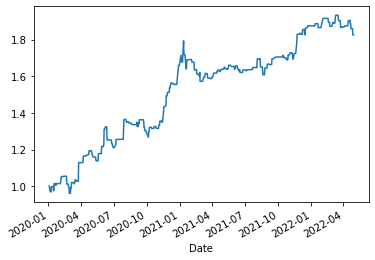

In [159]:
df['str_cum_rtn'].plot()

In [160]:
backtest_eval('str_cum_rtn','str_rtn')


cagr : 0.2992110530693959
sharp_ratio : 1.4282388585691228
Max_drawdown : -0.12318200796557954
Longest_dd_period : 316
Longest_dd_st_date : 2021-01-11 00:00:00
Longest_dd_ed_date : 2021-11-23 00:00:00
